In [1]:
from fastai.vision import *
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import optim
from torchsummary import summary
import gc
from fastai.callbacks import *
from fastai.utils.mem import *

In [2]:
# pre-trained VGG16 (with  batch norm) for feature loss
from torchvision.models import vgg16_bn

In [3]:
from ranger import Ranger

In [4]:
bs=6 #batch size
size=128 # image size (size x size)

# image paths
path_out = 'nicolascage2Me'
path_inp = 'Me2nicolascage'

In [5]:
# use gpu if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ImageDataBunch;

Train: LabelList (891 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: Me2nicolascage;

Valid: LabelList (98 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: Me2nicolascage;

Test: None

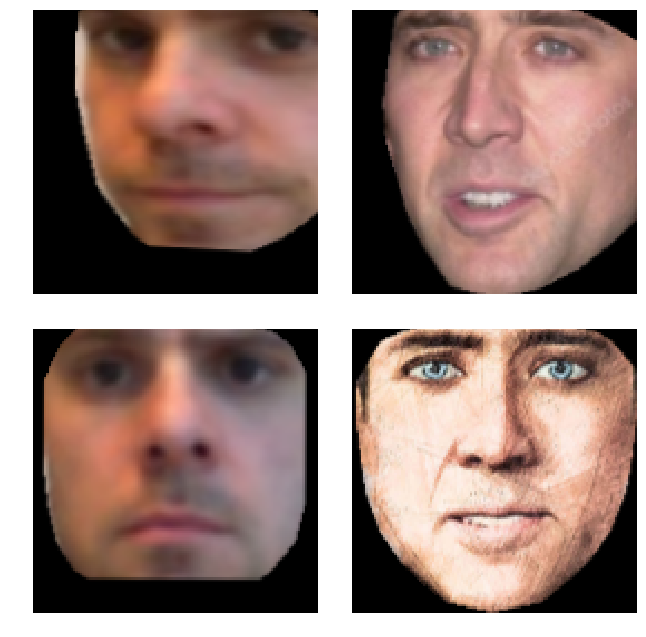

In [6]:
# create image 2 image databunch
# code from: ???
src = ImageImageList.from_folder(path_inp).split_by_rand_pct(0.1, seed=42)
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_out+'/'+x.name)
           .transform(get_transforms(), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data
data = get_data(bs,size)
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))
data

In [7]:
# predictive filter flow layer
# https://arxiv.org/abs/1811.11482
# Kong, S., & Fowlkes, C. (2018). Image reconstruction with predictive filter flow. arXiv preprint arXiv:1811.11482.
# - learn and apply individual filters (ksize x ksize) for each spatial position in the input
# - i.e. basically image warping, but instead of offsets, we learn a filter
class pFF(nn.Module):
    def __init__(self,ni, ksize=3,softmax = True,hard=False,upsample=1):
        super(pFF, self).__init__()
        # size of the learned filter: ksize x ksize
        self.ksize=ksize
        # use softmax or tanh
        self.softmax = softmax
        # force hard softmax or not
        self.hard = hard
        # upsampling of the learned filters (gives smoother result)
        self.upsample = upsample
        # train conv layer to output filter flow and use reflection padding
        self.get_filter = nn.Conv2d(ni,ksize**2,3,padding=1,padding_mode='reflect')
        self.pad = nn.ReflectionPad2d(padding=int((ksize-1)/2))
        # apply learned filters
        self.uf1 = nn.Unfold(ksize, dilation=1, padding=0, stride=1)
        self.uf2 = nn.Unfold(1, dilation=1, padding=0, stride=1)
        if upsample>1:
            self.us = nn.UpsamplingBilinear2d(scale_factor=upsample)
        
    def forward(self, features,inpt):
        # features: features learned by CNN, inpt: input that filters should be applied to
        # 1: get filter
        ff = self.get_filter(features)
        # 2: apply activation function
        if self.softmax:
            # different from paper: use gumbel softmax instead of softmax
            # - reason: more control (i.e. enforce hard softmax)
            ff = F.gumbel_softmax(ff,hard=self.hard,dim=1)
        else:
            ff = torch.tanh(ff)
        if self.upsample>1:
            ff = self.us(ff)
            
        # apply learned filters
        inp_pad = self.pad(inpt)
        
        ff = torch.cat([ff]*inpt.shape[1],dim=1)
#         print('FF1:',ff.shape)
        out = self.uf1(inp_pad) * self.uf2(ff)
        out = out.view(-1,inpt.shape[1],self.ksize**2,inpt.shape[2],inpt.shape[3])
        return out.sum(dim=2)
   

In [8]:
# Build U-Net for face2face translation usining predictive filter flow
# U-Net adapted from https://github.com/milesial/Pytorch-UNet
# - replaced transpose conv with PixelShuffle for efficiency
# - replaced conv2d with depthwise separable conv for efficiency
# - Use Mish activation function: code by https://github.com/lessw2020/mish
# - residual block in the middle
# - PReLU activation function in upsampling layers
# - predictive filter flow


class Mish(nn.Module):
    # source: https://github.com/lessw2020/mish
    def __init__(self):
        super().__init__()
    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))
    

class depthwise_separable_conv(nn.Module):
    # source: "shicai": https://discuss.pytorch.org/t/how-to-modify-a-conv2d-to-depthwise-separable-convolution/15843)
    def __init__(self, nin, nout,stride=1,ksize=3):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=ksize, padding=int((ksize-1)/2), groups=nin,stride=stride,padding_mode='reflect')
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)
    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out


class prelu_layer(nn.Module):
    '''(conv => BN => Mish) * 2'''
    def __init__(self, in_ch, out_ch,stride=1):
        super(prelu_layer, self).__init__()
        self.conv = nn.Sequential(
            depthwise_separable_conv(in_ch, out_ch,stride),
            nn.BatchNorm2d(out_ch),
            nn.PReLU(out_ch)
        )
    def forward(self, x):
        x = self.conv(x)
        return x


class block1(nn.Module):
    def __init__(self,ni,no,stride=2,last_act=True):
        super(block1, self).__init__()
        self.bottleneck = ni != no
        self.last_act = last_act
        self.stride=stride
        self.sconv1 = depthwise_separable_conv(ni,no,stride)
        self.sconv2 = depthwise_separable_conv(no,no)
        self.sconv3 = depthwise_separable_conv(no,no)
        self.normact0 = nn.Sequential(nn.BatchNorm2d(no),Mish())
        self.normact1 = nn.Sequential(nn.BatchNorm2d(no),Mish())
        self.normact2 = nn.Sequential(nn.BatchNorm2d(no),Mish())
    def forward(self,x):
        if self.stride>1 or self.bottleneck:
            x = self.normact0(self.sconv1(x))
        residual = x
        out = self.normact1(self.sconv2(x))
        out = self.sconv3(out)
        out += residual
        if self.last_act:
            out = self.normact2(out)
        return out


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = nn.Sequential(
            depthwise_separable_conv(in_ch, out_ch,1,7),
            Mish()
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.conv = block1(in_ch,out_ch,2)

    def forward(self, x):
        x = self.conv(x)
        return x

    
class res_block(nn.Module):
    def __init__(self, in_ch):
        super(res_block, self).__init__()
        self.resconv = nn.Sequential(
            block1(in_ch,in_ch,1,False),
            block1(in_ch,in_ch,1,False),
            block1(in_ch,in_ch,1,False),
            block1(in_ch,in_ch,1,False)
        )

    def forward(self, x):
        x = self.resconv(x)
        return x
    

class up(nn.Module):
    def __init__(self, in_ch,mid_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        self.ups = nn.modules.PixelShuffle(2)
        self.conv1 = prelu_layer(in_ch//4+mid_ch, out_ch,1)
        self.conv2 = prelu_layer(out_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.ups(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x  
    

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.inc = inconv(3, 64)
        self.down1 = down(64, 64)
        self.down2 = down(64, 128)
        self.down3 = down(128,256)
        self.down4 = down(256,256)
        self.res1 = res_block(256)
        
        self.up1 = up(256,256, 256)
        self.up2 = up(256,128, 128)
        self.up3 = up(128,64,64)
        self.up4 = up(64,64, 64)

        self.upsample = nn.UpsamplingBilinear2d(size)
        
        self.filter0 = pFF(64, ksize=21)
        self.filter1 = pFF(64, ksize=21)
        self.filter2 = pFF(64, ksize=11)
        
    def forward(self, inp):
        x1 = self.inc(inp)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.res1(x5)
        
        x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        filtered = self.filter0(x,inp)
        filtered = self.filter1(x,filtered)
        filtered = self.filter2(x,filtered)
    
        return filtered#torch.sigmoid(x)*4-1.6 #x

model = UNet()
model = model.to(device)
summary(model, input_size=(3, size,size))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 128, 128]             150
            Conv2d-2         [-1, 64, 128, 128]             256
depthwise_separable_conv-3         [-1, 64, 128, 128]               0
              Mish-4         [-1, 64, 128, 128]               0
            inconv-5         [-1, 64, 128, 128]               0
            Conv2d-6           [-1, 64, 64, 64]             640
            Conv2d-7           [-1, 64, 64, 64]           4,160
depthwise_separable_conv-8           [-1, 64, 64, 64]               0
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             Mish-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]             640
           Conv2d-12           [-1, 64, 64, 64]           4,160
depthwise_separable_conv-13           [-1, 64, 64, 64]               0
      BatchNorm2d-14

In [9]:
def charbonnier(y_pred, y_true):
    epsilon = 1e-3
    error = y_true - y_pred
    p = torch.sqrt(error**2 + epsilon**2)
    return torch.mean(p)


# Perceptual Loss:
# original code from: fast.ai lesson ???
# modifications:
# - Instance Normalization of low-level features to remove influence of "style"
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

base_loss = F.mse_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = [f'feat_{i}' for i in range(len(layer_ids))
                                         ]+ [f'gram_{i}' for i in range(len(layer_ids))]
        self.metric_names = [f'feat_{i}' for i in range(len(layer_ids))]
              

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        
        try:
            # instance normalization for all but last layer
            for l in range(len(in_feat)-1):
                in_feat[l] = nn.InstanceNorm2d(in_feat[l][1],momentum=0)(in_feat[l])
                out_feat[l] = nn.InstanceNorm2d(out_feat[l][1],momentum=0)(out_feat[l])
                
            self.feat_losses = [base_loss(f_in, f_out)*w
                                 for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
            self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                                 for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        except IndexError: # No idea why this tends to happen (only during validation)
            self.feat_losses = [torch.tensor(1).float().to(device)]
            for k in range(6):
                self.feat_losses += [torch.tensor(1).float().to(device)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()
        
        
feat_loss = FeatureLoss(vgg_m, blocks[2:8], [2,2,3,5,5,10])

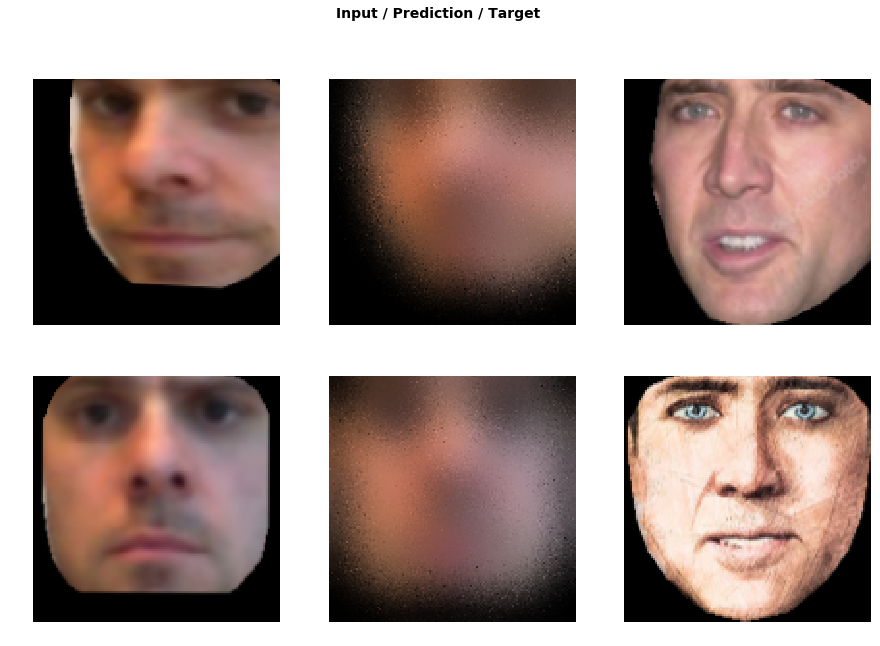

In [10]:
G = Learner(data,model,loss_func=feat_loss, opt_func=Ranger)
# G.load(path_inp+'2'+path_out)
gc.collect()
# show output before training
G.show_results(rows=2, imgsize=5)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


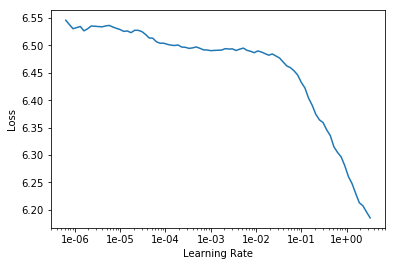

In [11]:
# find good learning rate
G.lr_find()
G.recorder.plot()

epoch,train_loss,valid_loss,time
0,5.495964,5.380821,00:46
1,5.412673,5.142126,00:46
2,5.353846,5.029445,00:46
3,5.306799,5.142537,00:46
4,5.289329,5.014592,00:46
5,5.266427,4.934975,00:46
6,5.267208,5.111701,00:46
7,5.245046,4.959285,00:46
8,5.287076,4.995072,00:46
9,5.237720,5.042600,00:46


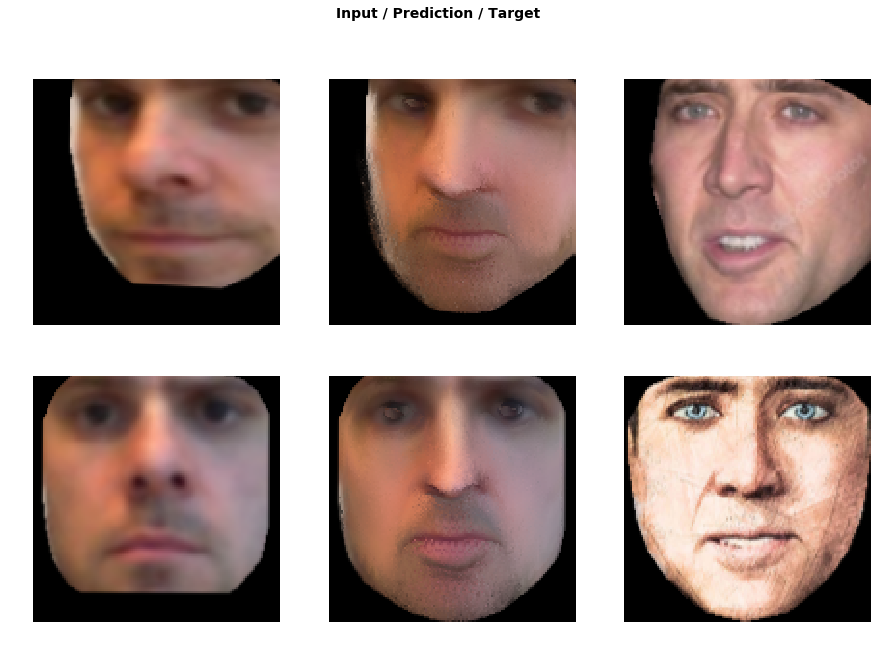

In [12]:
gc.collect()
G.fit_fc(12,1e-1)
# show intermediate results
G.show_results(rows=2, imgsize=5)

epoch,train_loss,valid_loss,time
0,5.008045,4.703616,00:46
1,4.977067,4.666568,00:46
2,4.987348,4.633422,00:46
3,4.968584,4.640472,00:46
4,4.920641,4.588225,00:46
5,4.920866,4.566501,00:46
6,4.921697,4.571353,00:46
7,4.906351,4.530913,00:46
8,4.882435,4.512670,00:46
9,4.826493,4.493728,00:46


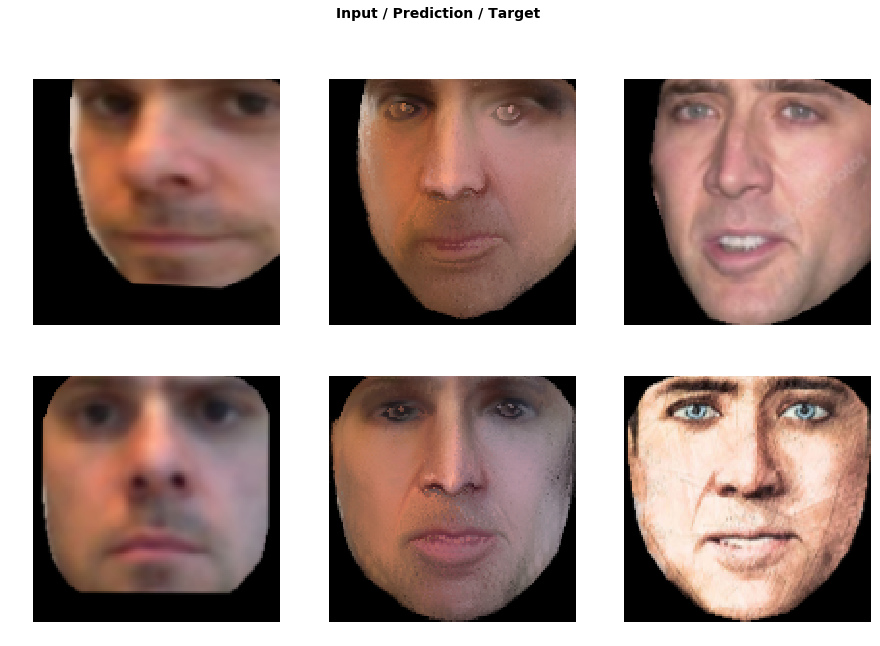

In [13]:
gc.collect()
G.fit_fc(55,1e-2)
# show final result
G.show_results(rows=2, imgsize=5)

epoch,train_loss,valid_loss,time
0,4.376716,3.979932,00:46
1,4.378586,3.986148,00:46
2,4.353267,3.972406,00:46
3,4.347459,3.969695,00:46
4,4.338584,3.967382,00:46
5,4.348273,3.961772,00:46
6,4.350857,3.956926,00:46
7,4.367878,3.958241,00:46
8,4.317196,3.952561,00:46
9,4.341398,3.957272,00:46


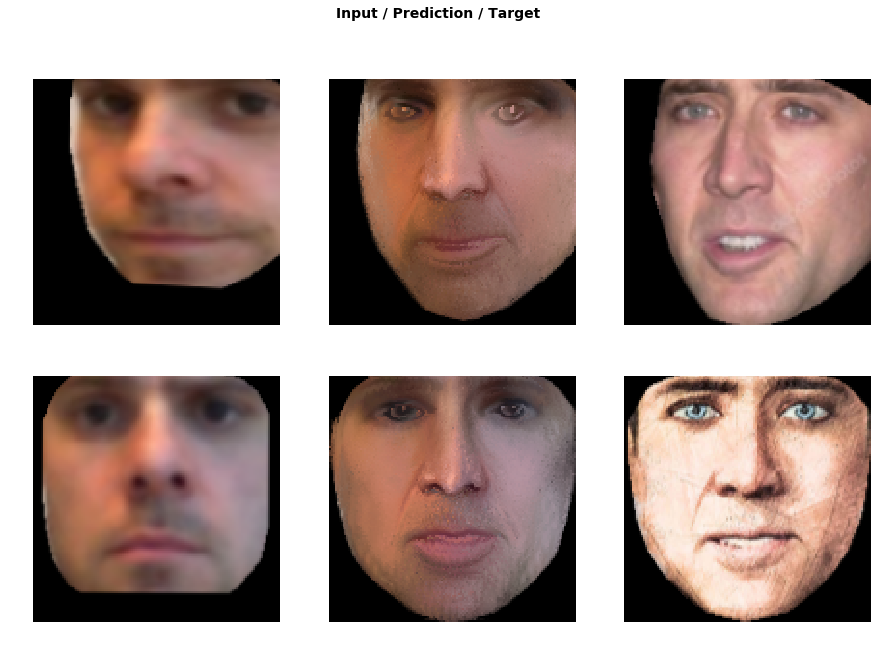

In [14]:
gc.collect()
G.fit_fc(55,1e-3)
# show final result
G.show_results(rows=2, imgsize=5)

epoch,train_loss,valid_loss,time
0,4.260930,3.867136,00:46
1,4.267951,3.868392,00:46
2,4.295352,3.870657,00:46
3,4.252035,3.867448,00:46
4,4.271282,3.868772,00:46
5,4.272082,3.870583,00:46
6,4.286391,3.869495,00:46
7,4.272246,3.869430,00:46
8,4.254820,3.867206,00:46
9,4.302187,3.874455,00:46


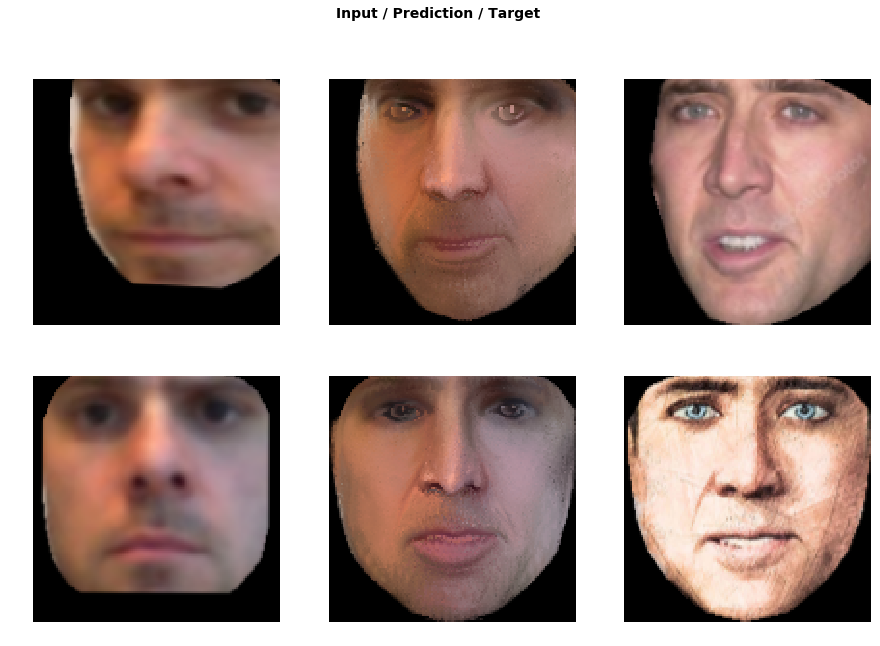

In [15]:
gc.collect()
G.fit_fc(55,1e-4)
G.show_results(rows=2, imgsize=5)

In [16]:
# save model
G.save(path_inp+'2'+path_out)

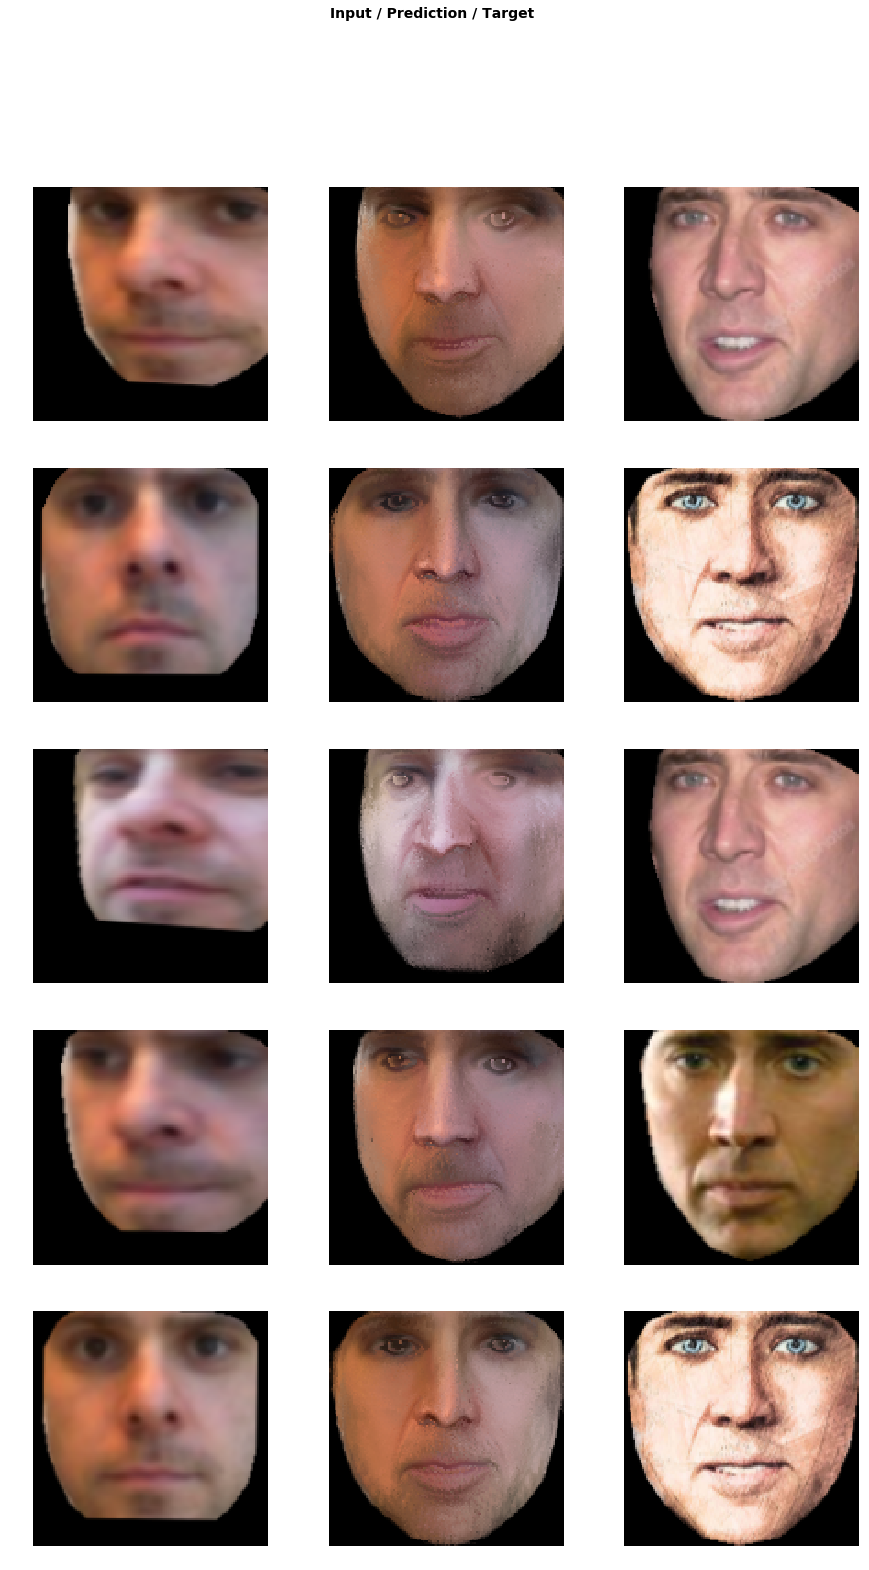

In [17]:
G.show_results(rows=5, imgsize=5)